# A6.2 Tic Tac Toe

For this assignment you will run a number of comparisons between different neural networks trained through Q-learning to predict Q functions for Player X and for Player O in a simple Tic Tac Toe game.  

All but one simple function is provided, so your effort will be in choosing the parameters for the experiments.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import neuralnetworks as nn

In [10]:
def initial_state():
    return np.array([0] * 9)

def next_state(s, a, marker):  # s is a board, and a is an index into the cells of the board, marker is 1 or -1
    s = s.copy()
    s[a] = 1 if marker == 'X' else -1
    return s

def reinforcement(s):
    if won('X', s):
        return 1
    if won('O', s):
        return -1
    return 0

def won(player, s):
    marker = 1 if player == 'X' else -1
    combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
    return np.any(np.all(marker == s[combos].reshape((-1, 3)), axis=1))

def draw(s):
    return sum(s == 0) == 0

def valid_actions(state):
    return np.where(state == 0)[0]

In [11]:
def stack_sa(s, a):
    return np.hstack((s, a)).reshape(1, -1)

def other_player(player):
    return 'X' if player == 'O' else 'O'

In [12]:
def epsilon_greedy(Qnet, state, epsilon):
    
    actions = valid_actions(state)
    
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
        
    else:
        # Greedy Move
        np.random.shuffle(actions)
        Qs = np.array([Qnet.use(stack_sa(state, a)) for a in actions])
        action = actions[np.argmax(Qs)]
        
    return action

In [13]:
def make_samples(Qnets, initial_state_f, next_state_f, reinforcement_f, epsilon):
    '''Run one game'''
    Samples = {'X': {'SA': [], 'R': [], 'Qn': []},
               'O': {'SA': [], 'R': [], 'Qn': []}}

    s = initial_state_f()
    player = 'X'

    while True:
        
        a = epsilon_greedy(Qnets[player], s, epsilon)
        sn = next_state_f(s, a, player)
        r = reinforcement_f(sn)

        Samples[player]['SA'].append(stack_sa(s, a))
        Samples[player]['R'].append(r)   # r is with respect to X
        Samples[player]['Qn'].append(0.0)  # fill in layer

        if r != 0 or draw(sn):
            Samples[other_player(player)]['R'][-1] = r  
            break

        s = sn
        player = other_player(player)  # switch

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['SA'] = np.vstack(Samps['SA'])
        Samps['R'] = np.array(Samps['R']).reshape(-1, 1)
        Samps['Qn'] =  np.array(Samps['Qn']).reshape(-1 ,1)  # this statement added in A6.1

    # Assign all Qn's, based on following state, but go every other state to do all X values,
    ends_with_O = len(Samples['X']) > len(Samples['O'])
    if ends_with_O:
        # O wins
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:, :])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])
    else:
        # X wins or draw
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['Qn'] = np.array(Samps['Qn']).reshape(-1, 1)

    return Samples

In [14]:
def plot_status(outcomes, epsilons, n_trials, trial):
    if trial == 0:
        return
    outcomes = np.array(outcomes)
    n_per = 10
    n_bins = (trial + 1) // n_per
    if n_bins == 0:
        return
    outcome_rows = outcomes[:n_per * n_bins].reshape((-1, n_per))
    outcome_rows = outcome_rows[:trial // n_per + 1, :]
    avgs = np.mean(outcome_rows, axis=1)
    
    plt.subplot(3, 1, 1)
    xs = np.linspace(n_per, n_per * n_bins, len(avgs))
    plt.plot(xs, avgs)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes') # \n(0=draw, 1=X win, -1=O win)')
    plt.title(f'Bins of {n_per:d} Games')
    
    plt.subplot(3, 1, 2)
    plt.plot(xs, np.sum(outcome_rows == -1, axis=1), 'r-', label='Losses')
    plt.plot(xs, np.sum(outcome_rows == 0, axis=1), 'b-', label='Draws')
    plt.plot(xs, np.sum(outcome_rows == 1, axis=1), 'g-', label='Wins')
    plt.legend(loc='center')
    plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
    
    plt.subplot(3, 1, 3)
    plt.plot(epsilons[:trial])
    plt.ylabel('$\epsilon$')

In [15]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.Xmeans = np.array(Xmeans)
    Qnet.Xstds = np.array(Xstds)
    Qnet.Tmeans = np.array(Tmeans)
    Qnet.Tstds = np.array(Tstds)

In [16]:
from IPython.display import display, clear_output

def run(X_hidden_units_list_of_lists, O_hidden_units_list_of_lists, n_epochs_list, learning_rate_list, 
        repetitions=5, graphics=False):
    
    if graphics:
        fig = plt.figure(figsize=(10, 10))
        
    n_trials = 8000         # number of repetitions of makeSamples-updateQ loop
    
    gamma = 1.0        # discount factor
    final_epsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials)) # to produce this final value

    results = []
    for n_epochs in n_epochs_list:
        for learning_rate in learning_rate_list:
            for X_nh in X_hidden_units_list_of_lists:
                for O_nh in O_hidden_units_list_of_lists:
                
                    last_fifth_outcomes = []

                    # RRn multiple experiments for these parameter values and average the results
                    for rep in range(repetitions):
                        
                        print(rep + 1, end=' ')
                        # Qnet for Player 'X'
                        QnetX = nn.NeuralNetwork(9 + 1, X_nh, 1)
                        # Qnet for Player 'O'
                        QnetO = nn.NeuralNetwork(9 + 1, O_nh, 1)
                        Qnets = {'X': QnetX, 'O': QnetO}

                        # Inputs are 9 TTT cells plus 1 action
                        setup_standardization(QnetX, [0] * 10, [1] * 10, [0], [1])
                        setup_standardization(QnetO, [0] * 10, [1] * 10, [0], [1])

                        epsilon = 1         # initial epsilon value
                        outcomes = []
                        epsilon_trace = []

                        # Train for n_trials
                        for trial in range(n_trials):

                            Samples = make_samples(Qnets, initial_state, next_state, reinforcement, epsilon)

                            Samps = Samples['X']
                            SA = Samps['SA']
                            R = Samps['R']
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['X'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            Samps = Samples['O']
                            SA = Samps['SA']
                            R = - Samps['R']  # r is with respect to X, so negate it
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['O'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            outcomes.append(Samples['X']['R'][-1])
                            epsilon_trace.append(epsilon)

                            epsilon *= epsilon_decay
                            
                            if graphics and (trial + 1 == n_trials or trial % (n_trials / 20) == 0):
                                plt.clf()
                                plot_status(outcomes, epsilon_trace, n_trials, trial)
                                clear_output(wait=True)
                                display(fig)

                        # For each repetition collect the mean of the outcome for the final fifth games
                        last_fifth_outcomes.append(np.mean(outcomes[-n_trials // 5:]))
                        print(f'{last_fifth_outcomes[-1]:.1f},', end=' ')
                        
                    results.append([X_nh, O_nh, n_epochs, learning_rate, np.mean(last_fifth_outcomes)])
                    print(results[-1])
                    
    if graphics:
        clear_output(wait=True)
        
    return pandas.DataFrame(results, columns=('X_nh', 'O_nh', 'n_epochs', 'lr', 'last_fifth_outcomes')), Qnets

Here is an example run with just one value for each of the four parameters.  Only 1 repetition will be performed.

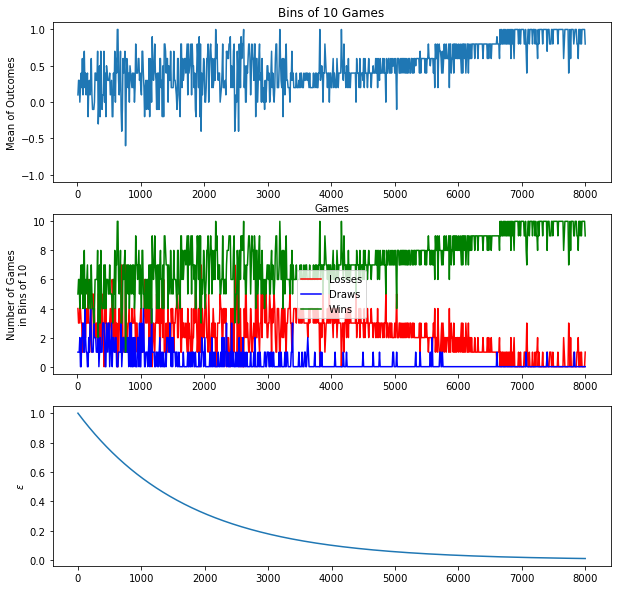

In [17]:
result, Qnets = run([[]], [[100, 20]], [40], [0.001], 1, True)

In [18]:
Qnets

{'X': NeuralNetwork(10, [], 1, 'tanh'),
 'O': NeuralNetwork(10, [100, 20], 1, 'tanh')}

In [19]:
print(Qnets['X'])
print(Qnets['O'])

NeuralNetwork(10, [], 1, 'tanh') trained for 40 epochs, final training error 0.0614
NeuralNetwork(10, [100, 20], 1, 'tanh') trained for 40 epochs, final training error 0.0147


Change the following function to compare different neural network structures for X and for O and also try multiple values for `n_epochs` and `learning_rate`.  Include the results of running your function in this notebook.

Try at least three different network structures for each player and three different values for `n_epochs` and three different values for `learning_rate`.  Use at least 5 for the second to last argument so your results are averaged over 5 repetitions. Try to find parameters for which O consistently wins, and ones for which X consistently wins. Include these choices in the lists of parameter values in the following function.

Discuss your results.  Do they make sense?

Here is an example run, though you must use at least three values for each of the first four arguments.

In [13]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[], [10, 10]],
                        O_hidden_units_list_of_lists=[[], [100, 20], [20, 20, 20]],
                        n_epochs_list=[40],
                        learning_rate_list=[0.001], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result

1 0.9, 2 0.9, 3 0.9, 4 0.9, 5 1.0, [[], [], 40, 0.001, 0.944]
1 0.9, 2 -0.7, 3 -0.8, 4 -0.8, 5 -0.8, [[], [100, 20], 40, 0.001, -0.45162500000000005]
1 -0.9, 2 0.4, 3 0.1, 4 -0.9, 5 0.8, [[], [20, 20, 20], 40, 0.001, -0.10187500000000001]
1 1.0, 2 1.0, 3 1.0, 4 1.0, 5 1.0, [[10, 10], [], 40, 0.001, 0.9647499999999999]
1 0.4, 2 0.9, 3 0.7, 4 0.8, 5 0.9, [[10, 10], [100, 20], 40, 0.001, 0.75575]
1 0.6, 2 0.5, 3 0.9, 4 0.8, 5 0.4, [[10, 10], [20, 20, 20], 40, 0.001, 0.639625]
Took 28.0 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],[],40,0.001,0.944000
1,[],"[100, 20]",40,0.001,-0.451625
2,[],"[20, 20, 20]",40,0.001,-0.101875
3,"[10, 10]",[],40,0.001,0.964750
4,"[10, 10]","[100, 20]",40,0.001,0.755750
5,"[10, 10]","[20, 20, 20]",40,0.001,0.639625


## Strategies for X winning

Took 803.8 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],[],40,0.0100,0.945125
1,[],"[20, 20]",40,0.0100,-0.235250
2,[],"[20, 20, 20]",40,0.0100,0.775000
3,"[20, 20]",[],40,0.0100,0.941750
4,"[20, 20]","[20, 20]",40,0.0100,0.794125
...,...,...,...,...,...
76,"[20, 20]","[20, 20]",60,0.0001,0.796625
77,"[20, 20]","[20, 20, 20]",60,0.0001,0.947500
78,"[30, 30]",[],60,0.0001,0.941500
79,"[30, 30]","[20, 20]",60,0.0001,0.759500


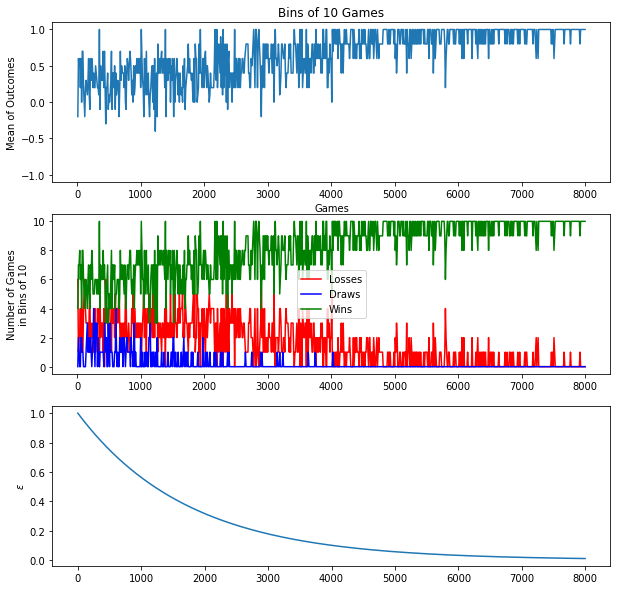

In [24]:
def myresult():
    resultX, QnetsX = run(X_hidden_units_list_of_lists=[[], [20, 20],[30,30]],
                        O_hidden_units_list_of_lists=[[], [20, 20], [20, 20, 20]],
                        n_epochs_list=[40,50,60],
                        learning_rate_list=[0.01,0.001, 0.0001], 
                        repetitions=5, graphics=True)
    return resultX

import time
start_timeX = time.time()

resultX = myresult()

print(f'Took {(time.time() - start_timeX) / 60.0:.1f} minutes.')

resultX

Copy a version of `myresult()` into next cell that contains a network architecture with which X can win the game.  If you cannot get X to win the game, put one of the strategies you tried here.

In [26]:
mx = 0
mx_i = 0
for c, v in enumerate (resultX['last_fifth_outcomes']):
    if v > mx:
        mx = v
        mx_i = c
print (resultX[mx_i:mx_i+1])

        X_nh          O_nh  n_epochs     lr  last_fifth_outcomes
14  [20, 20]  [20, 20, 20]        40  0.001              0.96625


Put your observations here.  If you cannot get X to win the game, discuss reasons why.

### According to the architecture above, even though "O" had more hidden layers compared to "X", the success  rate of  X winning is approximately 96.625%. With the weights being adjusted by learning rate of 0.001 and with the epoch of 40 in this scenario  X wins with less hidden layers.

## Strategies for O winning

Took 740.8 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],[],40,0.0100,0.942125
1,[],"[10, 10]",40,0.0100,0.394250
2,[],"[20, 20, 20]",40,0.0100,0.931875
3,[10],[],40,0.0100,0.945875
4,[10],"[10, 10]",40,0.0100,0.782625
...,...,...,...,...,...
76,[10],"[10, 10]",60,0.0001,0.824875
77,[10],"[20, 20, 20]",60,0.0001,0.947125
78,[20],[],60,0.0001,0.934625
79,[20],"[10, 10]",60,0.0001,0.750250


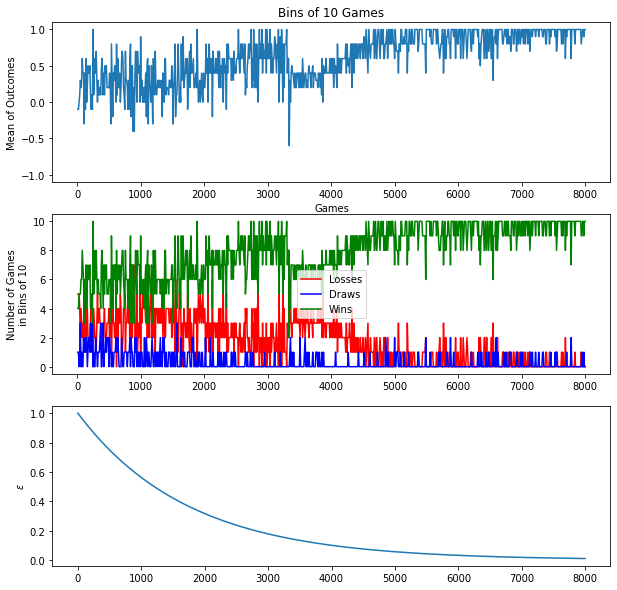

In [28]:
def myresult():
    resultO, QnetsO = run(X_hidden_units_list_of_lists=[[], [10],[20]],
                        O_hidden_units_list_of_lists=[[], [10,10], [20,20,20]],
                        n_epochs_list=[40,50,60],
                        learning_rate_list=[0.01,0.001,0.0001], 
                        repetitions=5, graphics=True)
    return resultO

import time
start_timeO = time.time()

resultO = myresult()

print(f'Took {(time.time() - start_timeO) / 60.0:.1f} minutes.')

resultO

Copy a version of `myresult()` into next cell that contains a network architecture with which O can win the game.  If you cannot get O to win the game, put one of the strategies you tried here.

In [29]:
mo = 0
mo_i = 0
for c, v in enumerate (resultO['last_fifth_outcomes']):
    if v < mo:
        mo = v
        mo_i = c
print (resultO[mo_i:mo_i+1])

   X_nh      O_nh  n_epochs     lr  last_fifth_outcomes
64   []  [10, 10]        60  0.001              -0.2115


Put your observations here.  If you cannot get O to win the game, discuss reasons why.

### From the outcome above we can say that the success rate of O winning is 21.15% which is pretty close to being draw than a win for O but it also shows that with no hidden layer for X and the number of of epochs needed to reach this outcome with the above learning rate we can say that there is no chance of X winning the game

## Grading and Check-in

*There is no grader script for this assignment.*  The entirety of your grade is based on trying the required number of experiments and presenting your results.

## Extra Credit

For 1 point of extra credit do the following steps.

1. Call `run` using your best parameter values and for 1 repetition.
2. Create four boards for which it is `X`'s turn. Using the returned `Qnets` print a display of the Q values generated by `Qnets['X']` in a 3 x 3 table corresponding to the tic tac toe board, for each of these four boards.
3. Create four boards for which it is `O`'s turn. Using the returned `Qnets` print a display of the Q values generated by `Qnets['O']` in a 3 x 3 table corresponding to the tic tac toe board, for these four boards.
4. Discuss the values.  Do they make sense?